# Basic Linear Programming: The Diet Problem

This notebook introduces the fundamentals of optimization modeling with LumiX through the classic **Diet Problem** - one of the earliest applications of linear programming, dating back to 1945.

## Problem Description

A person wants to determine the most **cost-effective** combination of foods that meets their **daily nutritional requirements**. Given a set of food items (each with cost and nutritional content) and minimum daily requirements for calories, protein, and calcium, we want to find the optimal number of servings of each food.

## Mathematical Formulation

**Decision Variables:**
$$x_f \geq 0 \quad \text{servings of food } f$$

**Objective (Minimize Total Cost):**
$$\min \sum_{f \in \text{Foods}} \text{cost}_f \cdot x_f$$

**Subject to:**
$$\sum_{f \in \text{Foods}} \text{calories}_f \cdot x_f \geq \text{MIN\_CALORIES}$$
$$\sum_{f \in \text{Foods}} \text{protein}_f \cdot x_f \geq \text{MIN\_PROTEIN}$$
$$\sum_{f \in \text{Foods}} \text{calcium}_f \cdot x_f \geq \text{MIN\_CALCIUM}$$

## Key Concepts Demonstrated

- **Variable families**: One `LXVariable` expands to multiple solver variables
- **Data-driven modeling**: Use `.from_data()` to auto-create variables from data
- **Automatic expansion**: Expressions sum over all data automatically
- **Type-safe coefficients**: Lambda functions extract data attributes
- **Fluent API**: Chain method calls for readable model building

## 1. Setup and Imports

In [1]:
# Standard library
from dataclasses import dataclass
from typing import List

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX optimization library
from lumix import LXConstraint, LXLinearExpression, LXModel, LXOptimizer, LXVariable

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 2. Data Definition

We define our food items and nutritional requirements using Python dataclasses. In a real application, this data might come from a database or CSV file.

In [2]:
@dataclass
class Food:
    """Represents a food item with nutritional information."""
    name: str
    cost_per_serving: float  # $ per serving
    calories: float          # calories per serving
    protein: float           # grams per serving
    calcium: float           # mg per serving


# Sample foods with nutritional data
FOODS = [
    Food("Oatmeal", 0.30, 110, 4, 2),
    Food("Chicken", 2.40, 205, 32, 12),
    Food("Eggs", 0.50, 160, 13, 60),
    Food("Milk", 0.60, 160, 8, 285),
    Food("Apple Pie", 1.60, 420, 4, 22),
    Food("Pork", 2.90, 260, 14, 10),
]

# Daily nutritional requirements (minimums)
MIN_CALORIES = 2000
MIN_PROTEIN = 50   # grams
MIN_CALCIUM = 800  # mg

print(f"Number of food options: {len(FOODS)}")
print(f"\nNutritional Requirements:")
print(f"  - Minimum Calories: {MIN_CALORIES}")
print(f"  - Minimum Protein: {MIN_PROTEIN}g")
print(f"  - Minimum Calcium: {MIN_CALCIUM}mg")

Number of food options: 6

Nutritional Requirements:
  - Minimum Calories: 2000
  - Minimum Protein: 50g
  - Minimum Calcium: 800mg


### Visualize the Food Data

In [3]:
# Create a DataFrame for easy visualization
df = pd.DataFrame([
    {
        'Food': f.name,
        'Cost ($)': f.cost_per_serving,
        'Calories': f.calories,
        'Protein (g)': f.protein,
        'Calcium (mg)': f.calcium
    }
    for f in FOODS
])

# Display the data
print("Food Nutritional Data:")
display(df.set_index('Food'))

Food Nutritional Data:


,Cost ($),Calories,Protein (g),Calcium (mg)
Food,,,,
Oatmeal,0.3,110,4,2
Chicken,2.4,205,32,12
Eggs,0.5,160,13,60
Milk,0.6,160,8,285
Apple Pie,1.6,420,4,22
Pork,2.9,260,14,10


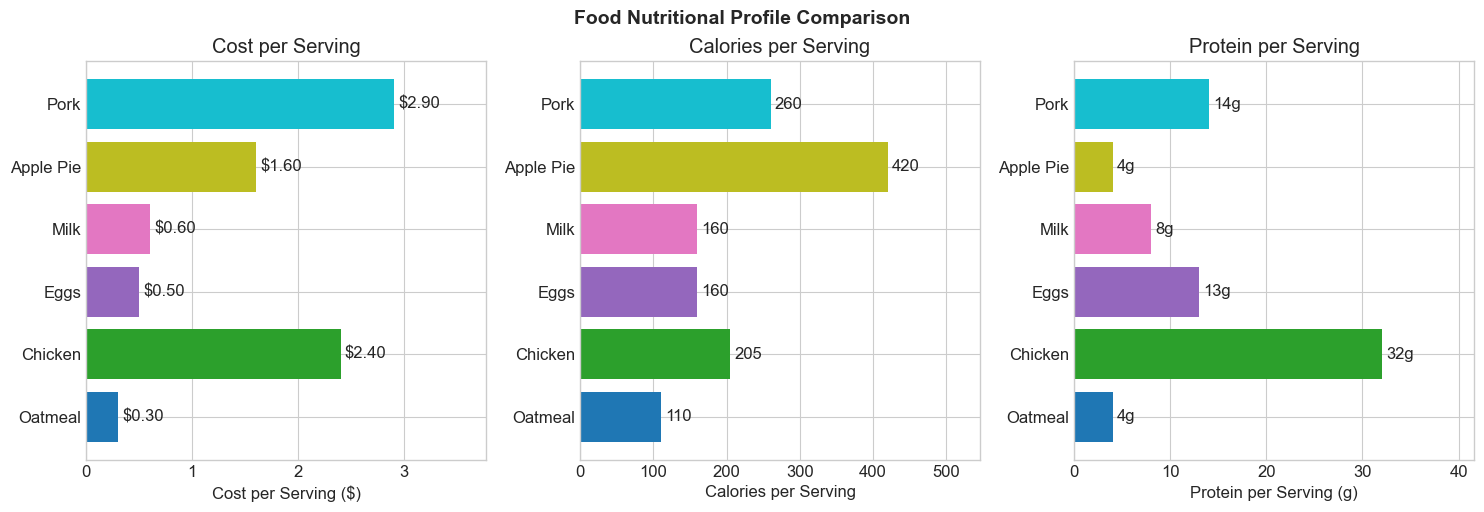

In [4]:
# Visualize cost vs nutritional value
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = plt.cm.tab10(np.linspace(0, 1, len(FOODS)))

# Cost per serving
ax1 = axes[0]
bars = ax1.barh([f.name for f in FOODS], [f.cost_per_serving for f in FOODS], color=colors)
ax1.set_xlabel('Cost per Serving ($)')
ax1.set_title('Cost per Serving')
ax1.bar_label(bars, fmt='$%.2f', padding=3)
ax1.set_xlim(0, max(f.cost_per_serving for f in FOODS) * 1.3)

# Calories per serving
ax2 = axes[1]
bars = ax2.barh([f.name for f in FOODS], [f.calories for f in FOODS], color=colors)
ax2.set_xlabel('Calories per Serving')
ax2.set_title('Calories per Serving')
ax2.bar_label(bars, fmt='%.0f', padding=3)
ax2.set_xlim(0, max(f.calories for f in FOODS) * 1.3)

# Protein per serving
ax3 = axes[2]
bars = ax3.barh([f.name for f in FOODS], [f.protein for f in FOODS], color=colors)
ax3.set_xlabel('Protein per Serving (g)')
ax3.set_title('Protein per Serving')
ax3.bar_label(bars, fmt='%.0fg', padding=3)
ax3.set_xlim(0, max(f.protein for f in FOODS) * 1.3)

plt.tight_layout()
plt.suptitle('Food Nutritional Profile Comparison', y=1.02, fontsize=14, fontweight='bold')
plt.show()

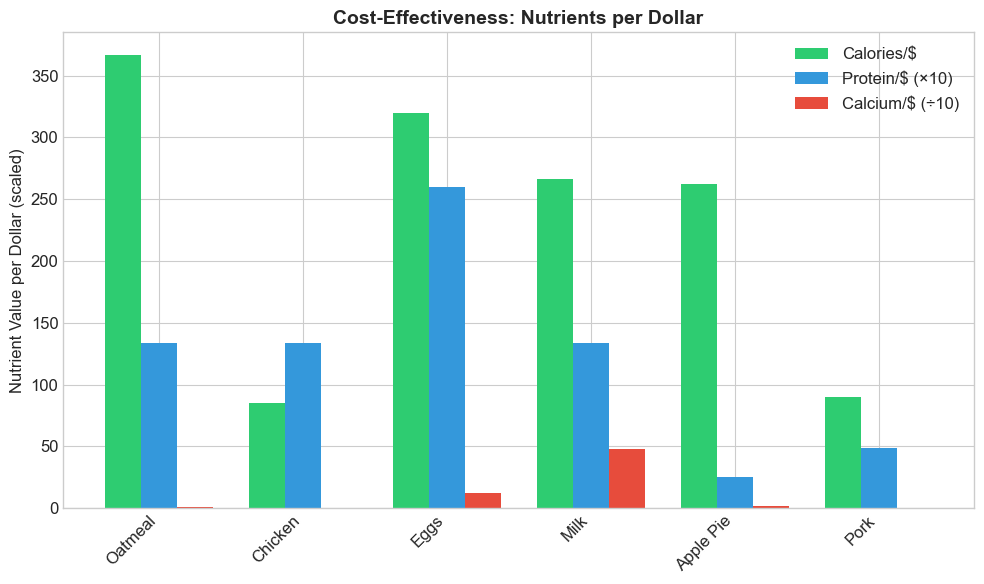

In [5]:
# Cost-effectiveness analysis: Nutrients per dollar
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(FOODS))
width = 0.25

# Calculate nutrients per dollar
calories_per_dollar = [f.calories / f.cost_per_serving for f in FOODS]
protein_per_dollar = [f.protein / f.cost_per_serving * 10 for f in FOODS]  # Scaled for visibility
calcium_per_dollar = [f.calcium / f.cost_per_serving / 10 for f in FOODS]  # Scaled for visibility

bars1 = ax.bar(x - width, calories_per_dollar, width, label='Calories/$', color='#2ecc71')
bars2 = ax.bar(x, protein_per_dollar, width, label='Protein/$ (×10)', color='#3498db')
bars3 = ax.bar(x + width, calcium_per_dollar, width, label='Calcium/$ (÷10)', color='#e74c3c')

ax.set_ylabel('Nutrient Value per Dollar (scaled)')
ax.set_title('Cost-Effectiveness: Nutrients per Dollar', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f.name for f in FOODS], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

## 3. Build the Optimization Model

Now we build the linear programming model using LumiX's fluent API. Note how:
- **One `LXVariable`** creates a *family* of variables indexed by food items
- **Lambda functions** extract coefficients from data automatically
- **Expressions** automatically sum over all data instances

In [6]:
def build_diet_model():
    """
    Build the diet optimization model using data-driven approach.
    
    Returns:
        Tuple of (model, servings variable) for type-safe solution access
    """
    
    # Decision Variable: Servings of each food (variable family)
    # ONE LXVariable that expands to multiple solver variables automatically
    servings = (
        LXVariable[Food, float]("servings")
        .continuous()
        .bounds(lower=0)
        .indexed_by(lambda f: f.name)  # Index by food name
        .from_data(FOODS)              # Data-driven: auto-expands to one var per food
    )

    # Create model and add the variable family
    model = LXModel("diet_problem").add_variable(servings)

    # Objective: Minimize total cost
    # Expression automatically sums over all foods
    cost_expr = LXLinearExpression().add_term(
        servings,
        coeff=lambda f: f.cost_per_serving  # Extract cost from each Food instance
    )
    model.minimize(cost_expr)

    # Constraint 1: Minimum calories
    model.add_constraint(
        LXConstraint("min_calories")
        .expression(
            LXLinearExpression().add_term(servings, lambda f: f.calories)
        )
        .ge()
        .rhs(MIN_CALORIES)
    )

    # Constraint 2: Minimum protein
    model.add_constraint(
        LXConstraint("min_protein")
        .expression(
            LXLinearExpression().add_term(servings, lambda f: f.protein)
        )
        .ge()
        .rhs(MIN_PROTEIN)
    )

    # Constraint 3: Minimum calcium
    model.add_constraint(
        LXConstraint("min_calcium")
        .expression(
            LXLinearExpression().add_term(servings, lambda f: f.calcium)
        )
        .ge()
        .rhs(MIN_CALCIUM)
    )

    return model, servings


# Build the model
model, servings = build_diet_model()

# Display model summary
print("Model Summary:")
print("=" * 50)
print(model.summary())

Model Summary:
LXModel: diet_problem
  Variable Families: 1
  Constraint Families: 3
  Objective: min



## 4. Solve the Model

We use the OR-Tools solver (free and open-source) to find the optimal solution.

In [7]:
# Create optimizer with OR-Tools solver
optimizer = LXOptimizer().use_solver("ortools")

# Solve the model
print("Solving the diet optimization problem...")
solution = optimizer.solve(model)

# Display solution status
print(f"\nSolution Status: {solution.status}")
print(f"Optimal Cost: ${solution.objective_value:.2f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 16:50:41 - lumix.optimizer - INFO - Created model 'diet_problem' with 1 variables and 3 constraints
2025-12-12 16:50:41 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 16:50:41 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 5.8975 | Time: 0.00s


Solving the diet optimization problem...

Solution Status: optimal
Optimal Cost: $5.90
Solve Time: 0.000s


## 5. Analyze the Results

In [8]:
# Extract solution values
food_by_name = {f.name: f for f in FOODS}
solution_data = []

total_cost = 0.0
total_calories = 0.0
total_protein = 0.0
total_calcium = 0.0

for food_name, servings_qty in solution.get_mapped(servings).items():
    food = food_by_name[food_name]
    cost = food.cost_per_serving * servings_qty
    calories = food.calories * servings_qty
    protein = food.protein * servings_qty
    calcium = food.calcium * servings_qty
    
    total_cost += cost
    total_calories += calories
    total_protein += protein
    total_calcium += calcium
    
    solution_data.append({
        'Food': food_name,
        'Servings': servings_qty,
        'Cost ($)': cost,
        'Calories': calories,
        'Protein (g)': protein,
        'Calcium (mg)': calcium
    })

# Create solution DataFrame
solution_df = pd.DataFrame(solution_data)

# Display optimal diet plan
print("\n" + "=" * 60)
print("OPTIMAL DIET PLAN")
print("=" * 60)

# Filter non-zero servings
nonzero_df = solution_df[solution_df['Servings'] > 0.01].copy()
nonzero_df = nonzero_df.round(2)
display(nonzero_df.set_index('Food'))

print("\n" + "-" * 60)
print("TOTALS")
print("-" * 60)
print(f"Total Cost:     ${total_cost:.2f}")
print(f"Total Calories: {total_calories:.1f} (min: {MIN_CALORIES})")
print(f"Total Protein:  {total_protein:.1f}g (min: {MIN_PROTEIN}g)")
print(f"Total Calcium:  {total_calcium:.1f}mg (min: {MIN_CALCIUM}mg)")


OPTIMAL DIET PLAN


,Servings,Cost ($),Calories,Protein (g),Calcium (mg)
Food,,,,,
Oatmeal,14.24,4.27,1566.87,56.98,28.49
Milk,2.71,1.62,433.13,21.66,771.51



------------------------------------------------------------
TOTALS
------------------------------------------------------------
Total Cost:     $5.90
Total Calories: 2000.0 (min: 2000)
Total Protein:  78.6g (min: 50g)
Total Calcium:  800.0mg (min: 800mg)


## 6. Visualize the Optimal Solution

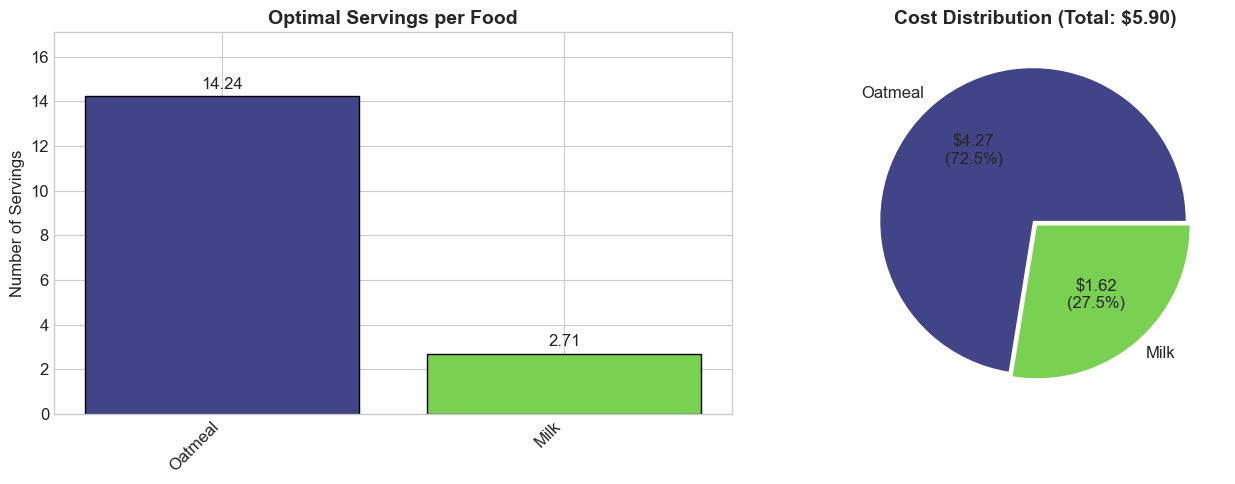

In [9]:
# Filter to non-zero servings for visualization
nonzero_foods = [(row['Food'], row['Servings'], row['Cost ($)']) 
                 for _, row in solution_df.iterrows() if row['Servings'] > 0.01]

if nonzero_foods:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Servings bar chart
    ax1 = axes[0]
    foods_names = [f[0] for f in nonzero_foods]
    servings_vals = [f[1] for f in nonzero_foods]
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(nonzero_foods)))
    
    bars = ax1.bar(foods_names, servings_vals, color=colors, edgecolor='black')
    ax1.set_ylabel('Number of Servings')
    ax1.set_title('Optimal Servings per Food', fontsize=14, fontweight='bold')
    ax1.bar_label(bars, fmt='%.2f', padding=3)
    ax1.set_ylim(0, max(servings_vals) * 1.2)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Cost pie chart
    ax2 = axes[1]
    costs = [f[2] for f in nonzero_foods]
    ax2.pie(costs, labels=foods_names, autopct=lambda pct: f'${pct/100*total_cost:.2f}\n({pct:.1f}%)', 
            colors=colors, explode=[0.02]*len(costs))
    ax2.set_title(f'Cost Distribution (Total: ${total_cost:.2f})', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No non-zero servings in optimal solution.")

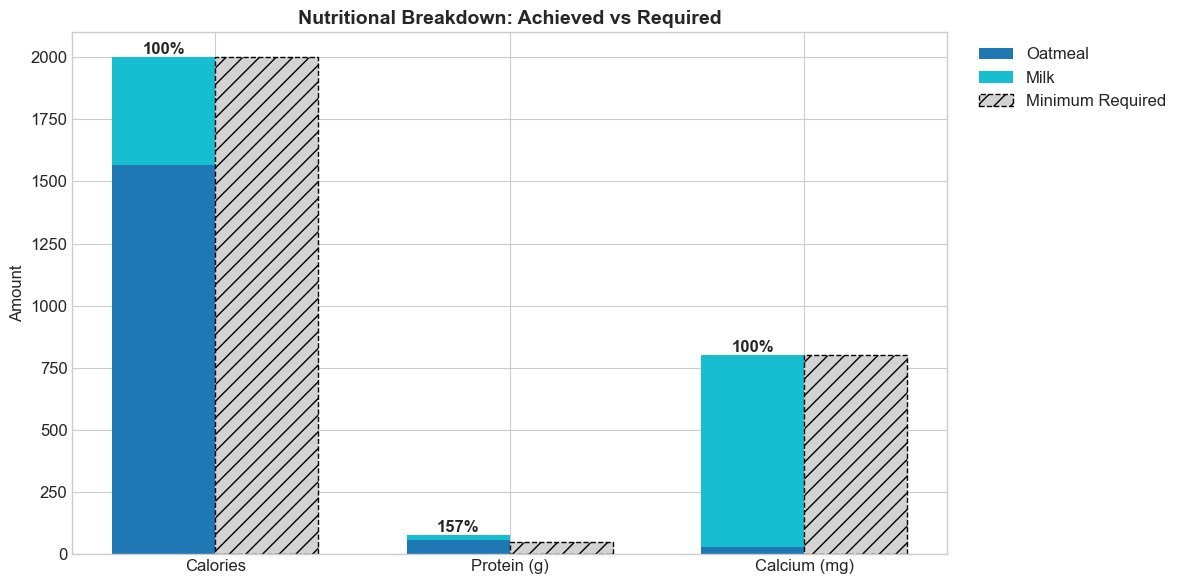

In [10]:
# Nutritional breakdown stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for stacked bar
nutrients = ['Calories', 'Protein (g)', 'Calcium (mg)']
requirements = [MIN_CALORIES, MIN_PROTEIN, MIN_CALCIUM]
achieved = [total_calories, total_protein, total_calcium]

# Food contributions (only non-zero)
nonzero_df_vis = solution_df[solution_df['Servings'] > 0.01]

x = np.arange(len(nutrients))
width = 0.35

# Create stacked bars for achieved nutrients
bottom = np.zeros(len(nutrients))
colors = plt.cm.tab10(np.linspace(0, 1, len(nonzero_df_vis)))

for i, (_, row) in enumerate(nonzero_df_vis.iterrows()):
    contributions = [row['Calories'], row['Protein (g)'], row['Calcium (mg)']]
    ax.bar(x - width/2, contributions, width, bottom=bottom, 
           label=row['Food'], color=colors[i])
    bottom += contributions

# Requirements bar
ax.bar(x + width/2, requirements, width, label='Minimum Required', 
       color='lightgray', edgecolor='black', linestyle='--', hatch='//')

# Add labels
ax.set_ylabel('Amount')
ax.set_title('Nutritional Breakdown: Achieved vs Required', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(nutrients)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Add percentage labels
for i, (ach, req) in enumerate(zip(achieved, requirements)):
    pct = (ach / req) * 100
    ax.annotate(f'{pct:.0f}%', (i - width/2, ach), 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

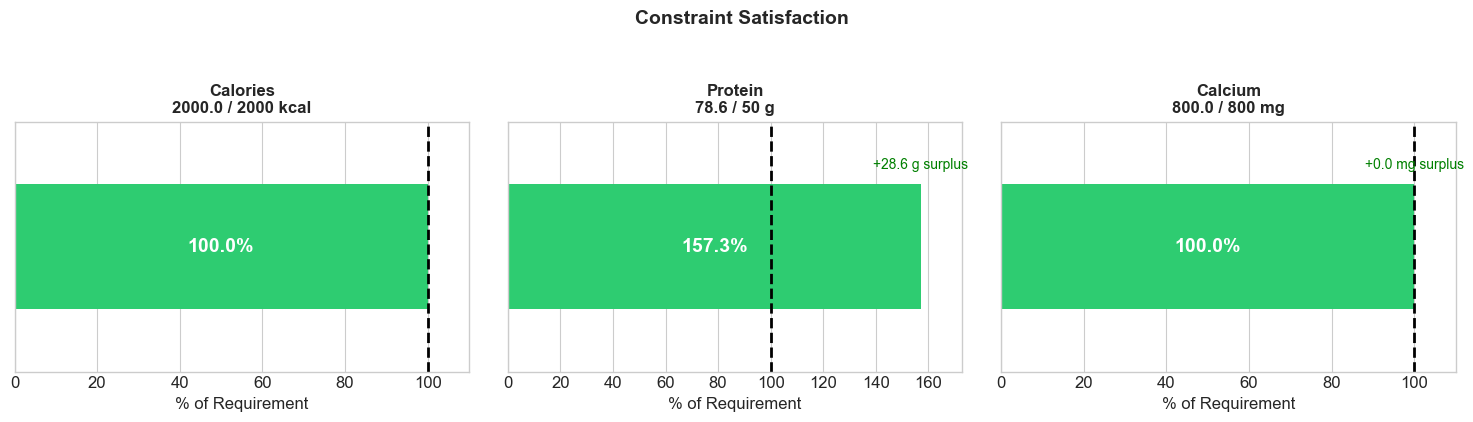

In [11]:
# Constraint satisfaction gauge chart
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

constraints = [
    ('Calories', total_calories, MIN_CALORIES, 'kcal'),
    ('Protein', total_protein, MIN_PROTEIN, 'g'),
    ('Calcium', total_calcium, MIN_CALCIUM, 'mg')
]

for ax, (name, achieved, required, unit) in zip(axes, constraints):
    # Create a simple gauge visualization
    percentage = (achieved / required) * 100
    surplus = achieved - required
    
    # Bar showing achievement
    color = '#2ecc71' if percentage >= 100 else '#e74c3c'
    ax.barh([0], [percentage], color=color, height=0.5)
    ax.axvline(x=100, color='black', linestyle='--', linewidth=2, label='Requirement')
    
    ax.set_xlim(0, max(percentage, 100) * 1.1)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('% of Requirement')
    ax.set_title(f'{name}\n{achieved:.1f} / {required:.0f} {unit}', fontsize=12, fontweight='bold')
    
    # Add percentage label
    ax.annotate(f'{percentage:.1f}%', (percentage/2, 0), 
                ha='center', va='center', fontsize=14, fontweight='bold', color='white')
    
    if surplus > 0:
        ax.annotate(f'+{surplus:.1f} {unit} surplus', (percentage, 0.3), 
                    ha='center', va='bottom', fontsize=10, color='green')

plt.suptitle('Constraint Satisfaction', y=1.05, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Key Insights

### What We Learned

1. **Variable Families**: A single `LXVariable` declaration creates multiple solver variables - one for each food item. This is LumiX's "data-driven" approach.

2. **Lambda Coefficients**: Instead of hardcoding numbers, we use lambda functions like `lambda f: f.cost_per_serving` to extract coefficients from data automatically.

3. **Automatic Summation**: When we add a term to an expression, LumiX automatically sums over all data instances.

4. **Type-Safe Access**: The solution provides values indexed by the same keys we used when defining variables.

### The Optimal Solution

The solver found that the cheapest diet meeting all nutritional requirements consists primarily of **Milk** (excellent calcium-per-dollar) and **Oatmeal** (cheap calories). This makes intuitive sense given the cost-effectiveness analysis we did earlier!

## 8. Extensions & Exercises

Try modifying this notebook to explore:

1. **Add Upper Bounds**: Limit maximum servings of any food (e.g., no more than 5 servings of any item)

2. **Add More Nutrients**: Include vitamins, fiber, or sodium constraints

3. **Variety Constraint**: Require at least 3 different foods in the diet

4. **Budget Constraint**: Add a maximum daily food budget

5. **Dietary Restrictions**: Exclude certain foods (e.g., vegetarian diet without Chicken and Pork)

In [ ]:
# Exercise hint: Adding upper bounds
# Modify the variable definition:
# servings = (
#     LXVariable[Food, float]("servings")
#     .continuous()
#     .bounds(lower=0, upper=5)  # <-- Add upper bound here
#     .indexed_by(lambda f: f.name)
#     .from_data(FOODS)
# )